# Short strategy example

An example short-only strategy using bollinger bands.

## Github notebook rendering issues

**If you are viewing this file on Github**: The current Github online notebook viewer cannot render the interactive Plotly charts used in this notebook.
To view the charts, you need to download run the notebook locally.

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [42]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc_poly

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1d

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.d1

# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# Which lending reserves we are using for supplying/borrowing assets
LENDING_RESERVES = [
    (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
    (ChainId.polygon, LendingProtocolType.aave_v3, "USDC"),
]

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.50

# Start with this amount of USD
INITIAL_DEPOSIT = 5_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m15

#
# Strategy thinking specific parameter
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 90

# Moving average 
# 
# How many candles to smooth out for Bollinger band's middle line
EMA_CANDLE_COUNT = 20  

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

# RSI must be above this value to open a new position
RSI_THRESHOLD = 10

# Backtest range
START_AT = datetime.datetime(2022, 12, 1)

# Backtest range
END_AT = datetime.datetime(2023, 4, 1)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded


In [50]:
from typing import List, Dict

from pandas_ta import bbands
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        strategy_universe: TradingStrategyUniverse,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """
    universe = strategy_universe.universe

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # Here we manipulate the pair trading fee.
    # A live trading would happen on Polygon Uniswap v3 ETH-USDC pool with 0.05% LP fee.
    # But this pool was deployed only couple of weeks back, so we do not have backtesting history for it.
    # Thus, we are backtesting with QuickSwap ETH-USDC pair that has 0.30% LP fee tier, which
    # we need to bump down to reflect the live trading situation.
    # Drop the fee to 5 BPSs.
    pair.fee = 0.0005

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    moving_average = ema(close_prices, length=EMA_CANDLE_COUNT)

    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]

    trades = []

    if moving_average is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting buffer yet.
        return trades

    price_latest = close_prices.iloc[-1]

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    # Calculate Bollinger Bands with a 20-day SMA and 2 standard deviations using pandas_ta
    # See documentation here https://tradingstrategy.ai/docs/programming/api/technical-analysis/volatility/help/pandas_ta.volatility.bbands.html#bbands
    bollinger_bands = bbands(close_prices, length=20, std=2)
    bb_upper = bollinger_bands["BBU_20_2.0"]
    bb_lower = bollinger_bands["BBL_20_2.0"]

    if not position_manager.is_any_open():
        # No open positions, decide if short in this cycle.
        # We buy if the price on the daily chart closes under the lower Bollinger Band.
        if price_latest < bb_lower.iloc[-1]:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_short(pair, amount, leverage=2, stop_loss_pct=STOP_LOSS_PCT)
            trades.extend(new_trades)

    else:
        # We have an open position, decide if SELL in this cycle.
        # We close the position when the price closes above the 20-day moving average.        
        if price_latest > moving_average.iloc[-1]:
            new_trades = position_manager.close_all()
            trades.extend(new_trades)
        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "BB upper", PlotKind.technical_indicator_on_price, bb_upper.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "BB lower", PlotKind.technical_indicator_on_price, bb_lower.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, moving_average.iloc[-1], colour="darkgreen")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [44]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=LENDING_RESERVES,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    strategy_universe = TradingStrategyUniverse.create_single_pair_universe(dataset)

    return strategy_universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [45]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/h25/.tradingstrategy


## Load data

In [46]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions(
        start_at=START_AT,
        end_at=END_AT,
    )
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

We loaded 212 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [51]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="BB short example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    engine_version="0.3",
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/10454400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 6 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [52]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 3
Trades made: 6


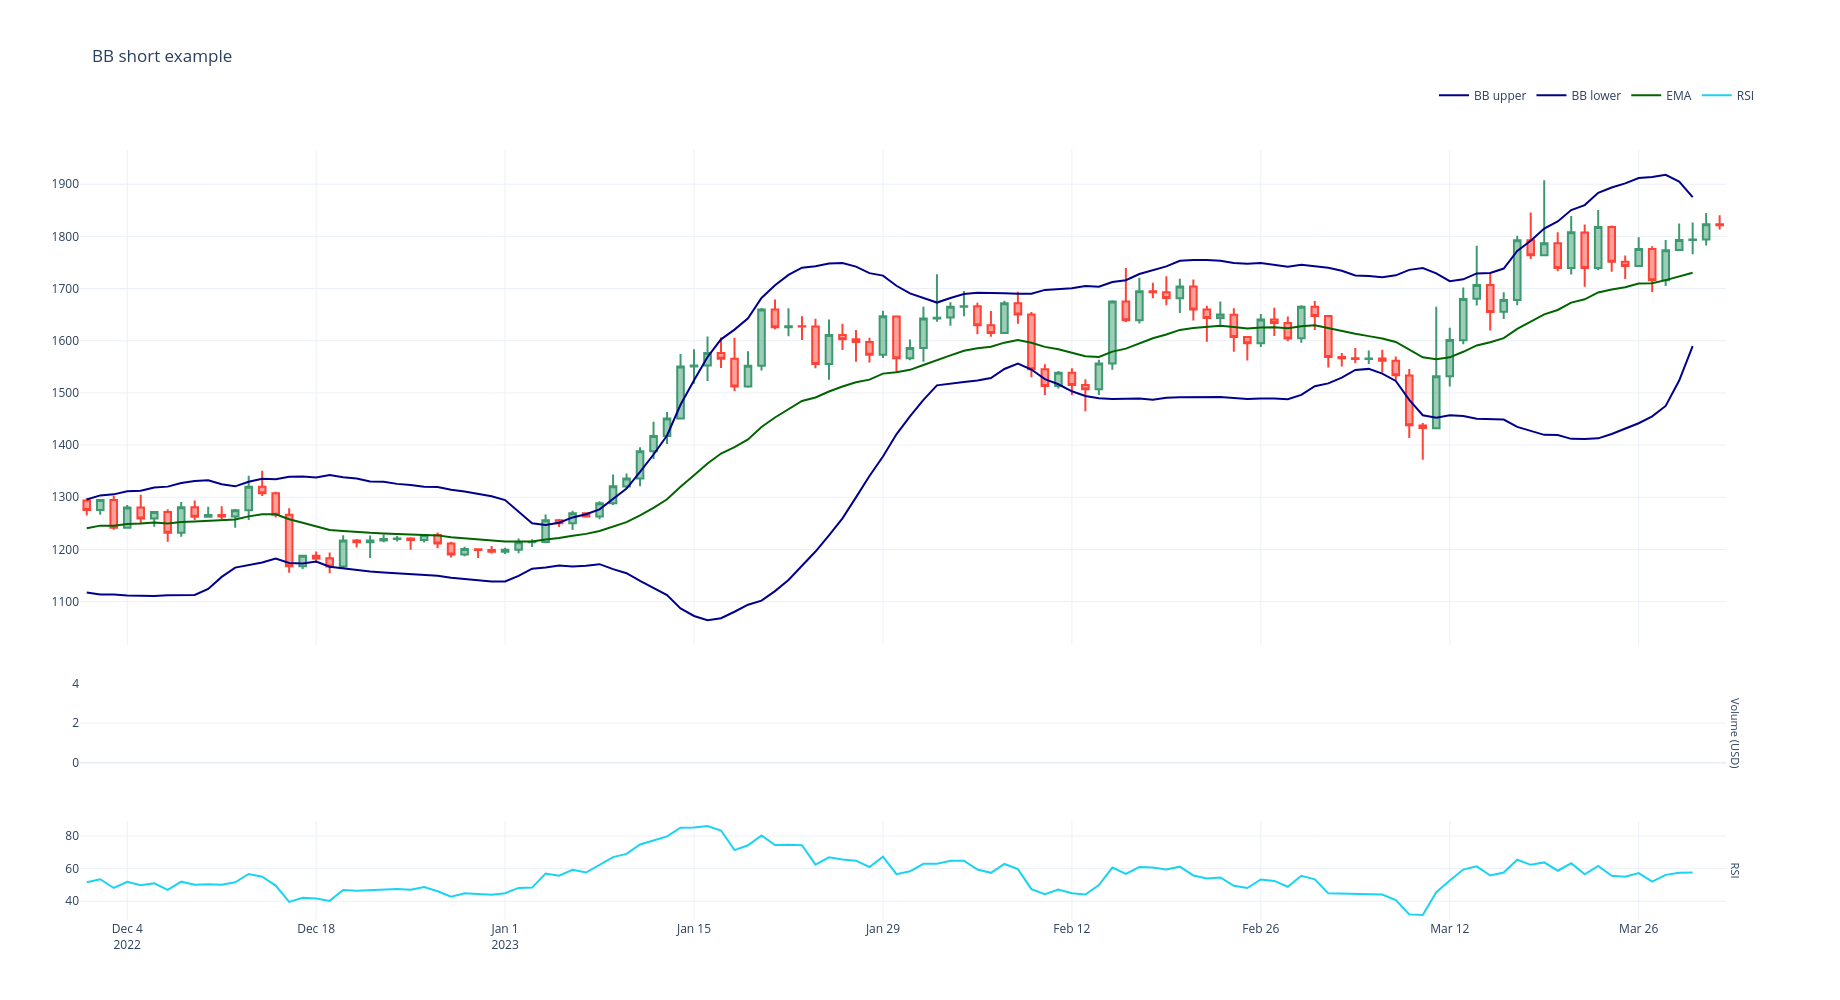

In [53]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

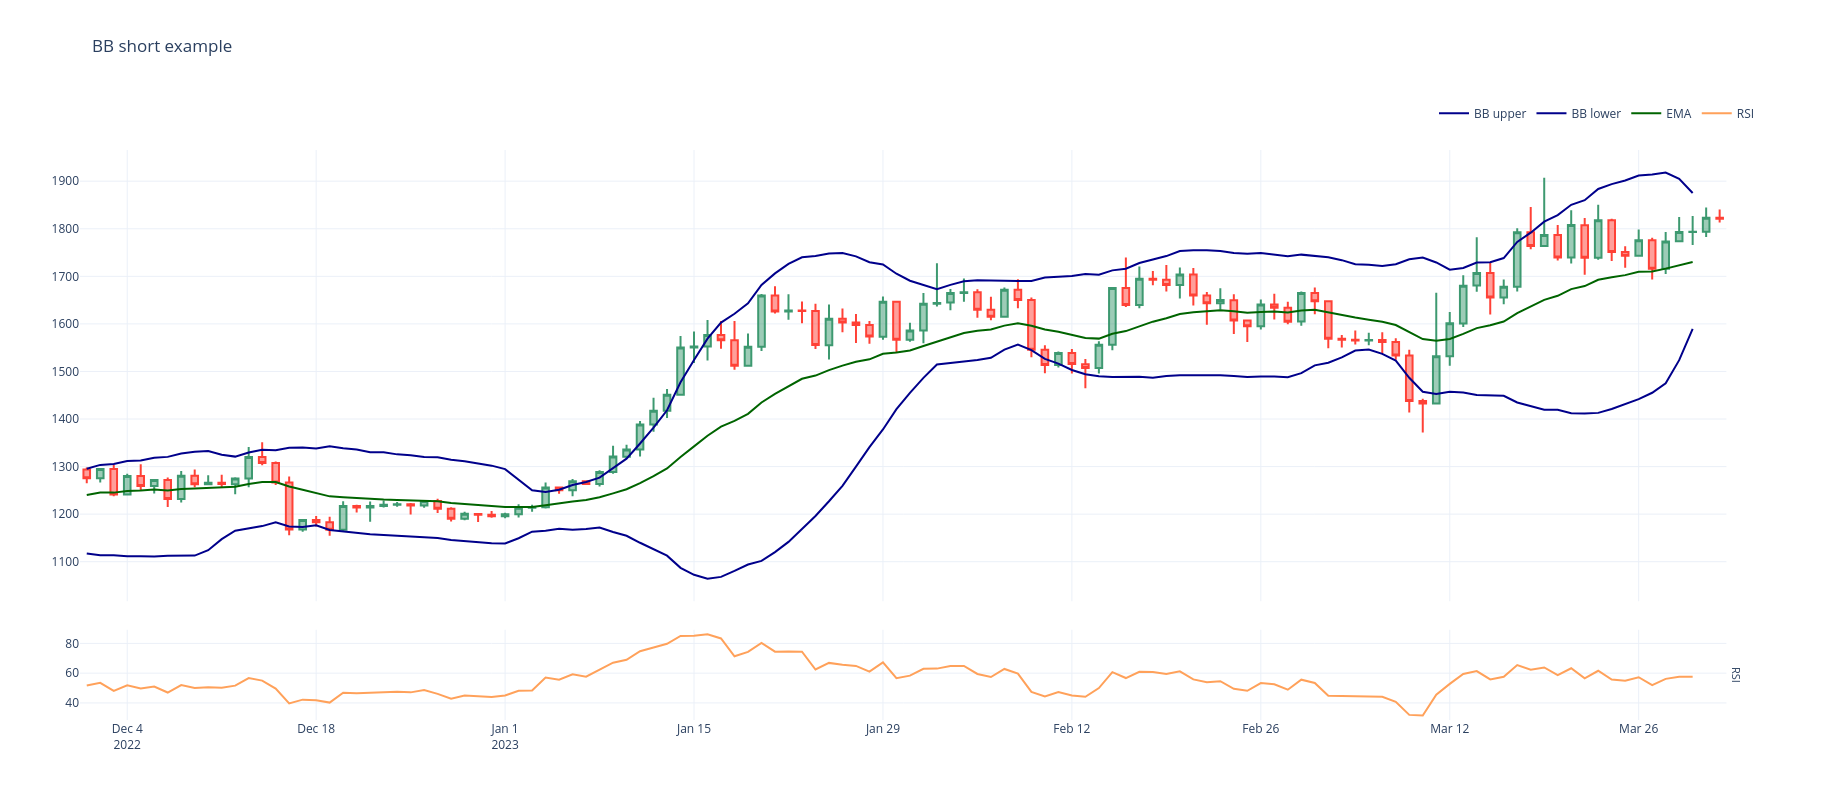

In [54]:
candles = universe.universe.candles.get_candles_by_pair(universe.get_single_pair().internal_id)

figure2 = visualise_single_pair_positions_with_duration_and_slippage(
    state,
    candles,
    start_at=START_AT,
    end_at=END_AT,
)

figure2.show()

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


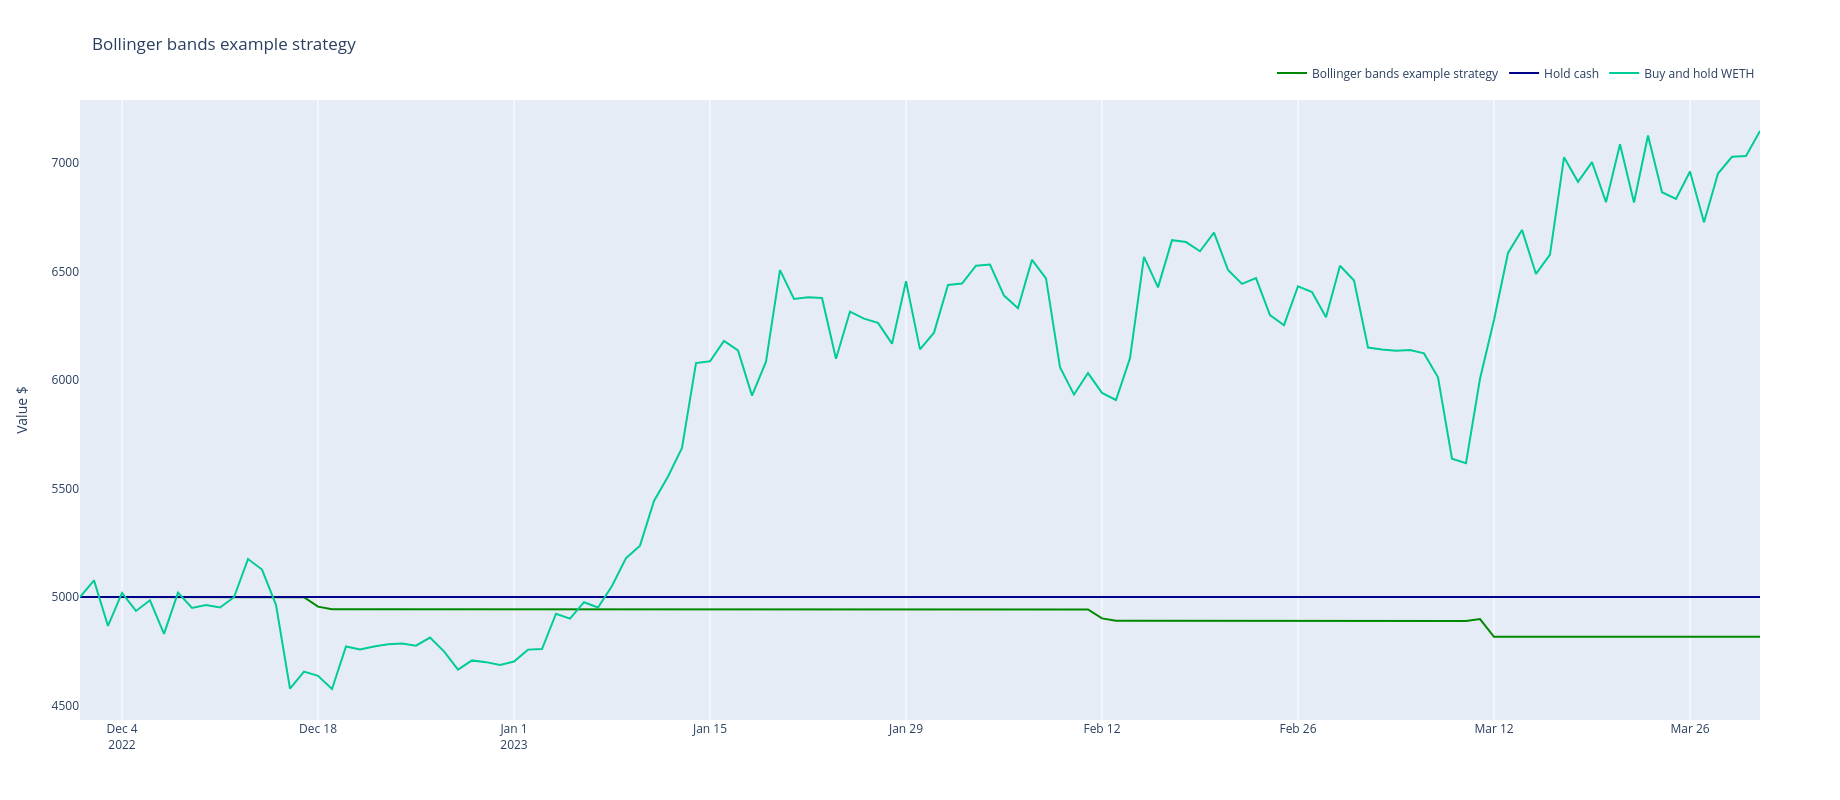

In [55]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Bollinger bands example strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [56]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [57]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

AssertionError: Only long positions supported

### Position and trade timeline

Display all positions and how much profit they made.

In [ ]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")